In [117]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
import json

In [118]:
file_name = "9M-5-[1-2001]-[a]-lcm.out"
output_file = f"queries_results/python_{file_name.replace('out','csv')}"

In [381]:
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name}.npy')

def splited_links():
    links = pd.read_csv(f"../../plots/links/{file_name}")
    res = []
    links.apply(lambda x : [res.append((x["source"],x["target"], int(i) )) for i in x["user_id"].split(",")] ,axis=1)
    return  pd.DataFrame(res,columns=["source","target","user_id"])
def partial_df():
    # Groupes over two periods only
    links = splited_links()
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval)
    links = links.merge(groups.reset_index(),left_on="source",right_on='index').merge(groups.reset_index(),left_on="target",right_on='index')
    links.drop(["source","target","index_x","index_y","user_ids_x","user_ids_y"],axis=1,inplace=True)
    return links
def full_df():
    # Groups over three periods only
    links = splited_links()
    links = links.merge(links,left_on=["target","user_id"],right_on=["source","user_id"]).drop(["source_y"],axis=1)
    
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values","user_ids"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    
    links = links.merge(groups,left_on="source_x",right_index=True).merge(groups,left_on="target_x",right_index=True).merge(groups,left_on="target_y",right_index=True)
    links = links.rename(columns={"itemsets":"itemsets_z","period":"period_z"})
    links.drop(["source_x","target_x","target_y"],axis=1,inplace=True)
    return links

with open("../../datasets/Total/ids_mapping.json","r") as file:
    mapping = json.load(file)
def extract_user_stats(x,columns):
    user = x["user_id"]
    for col in columns:
        for val in x[col]:
            res.append((user,col,val))

## Queries

In [359]:
df=full_df()
df.head()

,user_id,itemsets_x,period_x,itemsets_y,period_y,itemsets_z,period_z
0,129151,{3425909000482},2018-09-01,{3425909002011},2018-12-01,"{3425909000482, 3217770310919}",2019-02-01
1,129151,{3425909000482},2018-09-01,{3425909002011},2018-12-01,{3217770310919},2019-02-01
2174,549038,{3425909001007},2018-09-01,{3425909001007},2018-12-01,{3217770310919},2019-02-01
3987,267956,{3425909001007},2018-09-01,{3425909001007},2018-12-01,{3217770310919},2019-02-01
2146,549038,"{6206300219508, 3425909001007}",2018-09-01,{3425909001007},2018-12-01,{3217770310919},2019-02-01


In [360]:
df["adoption"] = df.apply(lambda x: x["itemsets_y"].difference(x["itemsets_x"]),axis=1)
df["loyalty1"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_x"]),axis=1)
df["loyalty2"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_z"]),axis=1)

df["promo_exclusive_products"] = df.apply(lambda x : x["itemsets_y"].difference(x["itemsets_x"]).difference(x["itemsets_z"]),axis=1)
df["replacement"] = df.apply(lambda x : x["itemsets_x"].intersection(x["itemsets_y"]).difference(x["itemsets_z"]),axis=1)
df["loyalty"] = df.apply(lambda x :x["itemsets_x"].intersection(x["itemsets_y"].intersection(x["itemsets_z"])),axis=1)

# Stats

In [384]:
users= pd.read_csv("../../datasets/Total/users.csv",sep=";")
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0).drop("IDS_LIST",axis=1)
res = []
queries_columns = df.columns.tolist()[7:]
df.apply(lambda x : extract_user_stats(x,queries_columns),axis=1)
stats_df = pd.DataFrame(res,columns=["CUST_ID","query_type","ARTICLE_ID"])
stats_df = stats_df.merge(users).merge(items)
stats_df.head()

,CUST_ID,query_type,ARTICLE_ID,SEX,AGE,DEPARTEMENT,DESCRIPTION
0,129151,adoption,3425909002011,M,35-49,62,RECHARGE LAVAGE TW - D
1,129151,promo_exclusive_products,3425909002011,M,35-49,62,RECHARGE LAVAGE TW - D
2,129151,adoption,3425909002011,M,35-49,62,RECHARGE LAVAGE TW - D
3,129151,promo_exclusive_products,3425909002011,M,35-49,62,RECHARGE LAVAGE TW - D
4,129151,adoption,3425909002011,M,35-49,62,RECHARGE LAVAGE TW - D


### By users

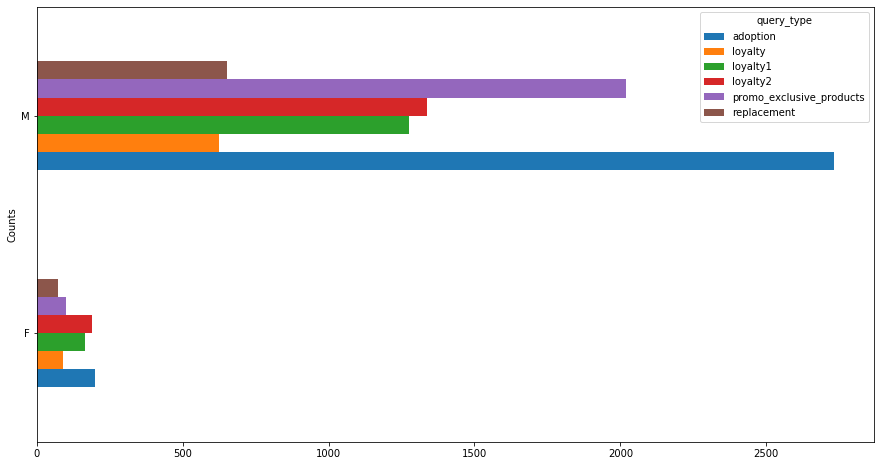

In [385]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

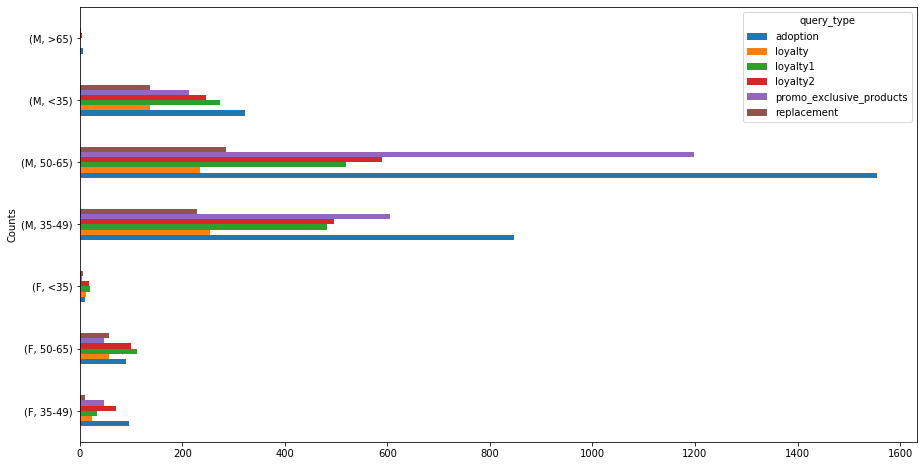

In [369]:
ax = stats_df.groupby(["SEX","AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

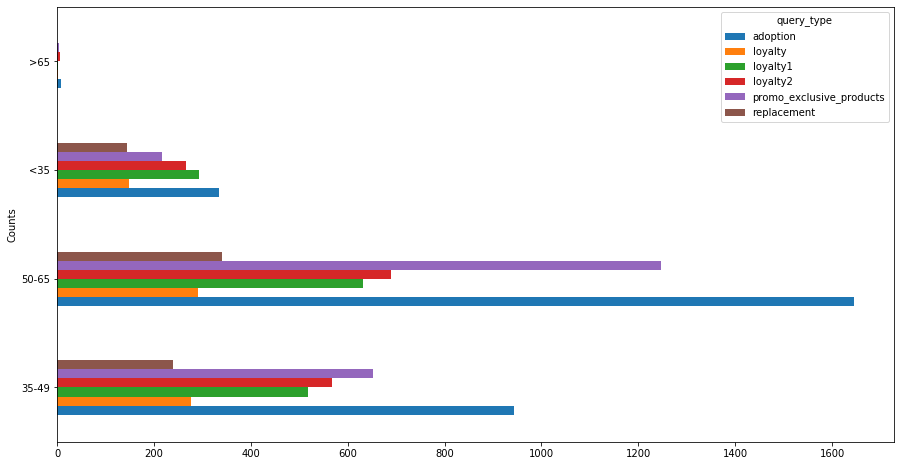

In [370]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

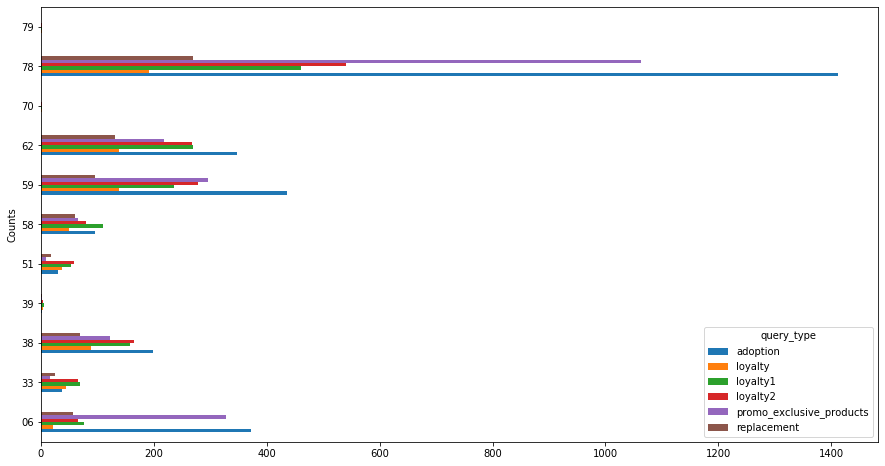

In [371]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### By items

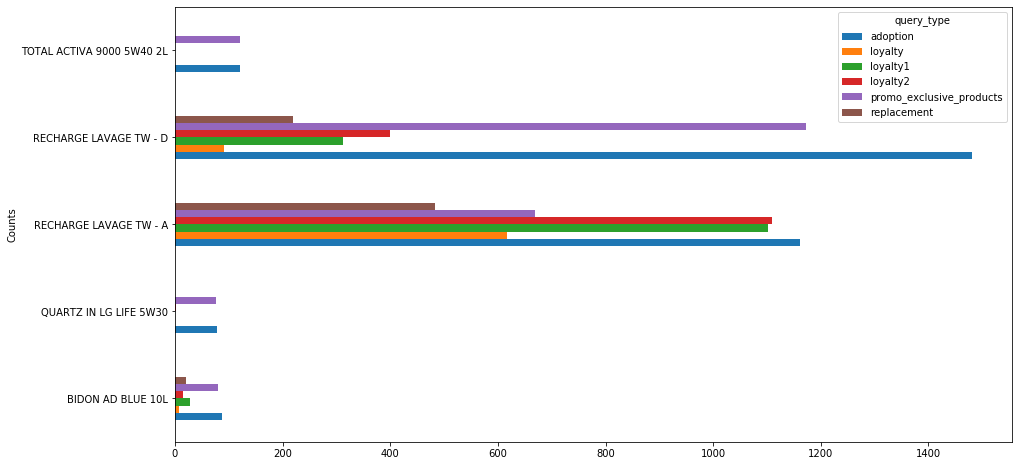

In [386]:
ax = stats_df.groupby(["DESCRIPTION"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

,DESCRIPTION,adoption_counts,loyalty1_counts,loyalty2_counts
ARTICLE_ID,,,,
3425909001007,RECHARGE LAVAGE TW - A,96,21,29
3425909002011,RECHARGE LAVAGE TW - D,91,7,11
3425901018140,BIDON AD BLUE 10L,28,2,2
3425901028170,QUARTZ IN LG LIFE 5W30,15,0,1
3019081236250,1 6 RILLETTES THON 125G,0,0,0
...,...,...,...,...
3700619604725,ZIGOH DESO FLEUR FUSHIA,0,0,0
3103220009055,ZIGOTO REGLISSE,0,0,0
3700300542008,ZIP AMIS LUDENDO,0,0,0


## Queries over three periods

In [322]:
df = full_df()
df.head()

,user_id,itemsets_x,itemsets_y,itemsets_z
0,129151,{3425909000482},{3425909002011},"{3425909000482, 3217770310919}"
1,129151,{3425909000482},{3425909002011},{3217770310919}
2174,549038,{3425909001007},{3425909001007},{3217770310919}
3987,267956,{3425909001007},{3425909001007},{3217770310919}
2146,549038,"{6206300219508, 3425909001007}",{3425909001007},{3217770310919}


### Stats by items 

In [298]:
# Initiate score to 0
columns = df.columns[4:].tolist()
for i in columns:
    items[i] = 0 
def extract_stats(x,items,columns):
    for i in columns:
        for j in x[i]:
            items.loc[j,i] += 1
e = df.apply(lambda x : extract_stats(x,items,columns),axis=1)

In [299]:
promo_products = pd.read_csv("../../datasets/Total/promo_products.csv").ARTICLE_ID.unique()
items.loc[promo_products].sort_values(by=columns,ascending=False).head(10)

,DESCRIPTION,adoption_counts,loyalty1_counts,loyalty2_counts,promo_exclusive_products,replacement,loyalty
ARTICLE_ID,,,,,,,
3425909002011,RECHARGE LAVAGE TW - D,91,7,11,1173,220,92
3425909001007,RECHARGE LAVAGE TW - A,96,21,29,669,484,617
3425901018720,TOTAL ACTIVA 9000 5W40 2L,15,0,0,120,0,0
3425901018140,BIDON AD BLUE 10L,28,2,2,80,21,7
3425901028170,QUARTZ IN LG LIFE 5W30,15,0,1,77,0,0
3425901014890,ACTIVA 5000 ESS 15W40,0,0,0,0,0,0
3425901019178,ACTIVA 7000E 5L,0,0,0,0,0,0
3425900000962,ACTIVA 9000 1L 5W40,0,0,0,0,0,0
3011449262970,ACTIVA 9000 5W4,0,0,0,0,0,0


### Stats by users

In [220]:
res = []         
df.apply(lambda x : extract_user_stats(x,columns),axis=1)
stats_df = pd.DataFrame(res,columns=["user_id","query_type","product_id"])
stats_df = stats_df.merge(users,left_on="user_id",right_on="CUST_ID").drop("user_id",axis=1).set_index("CUST_ID")

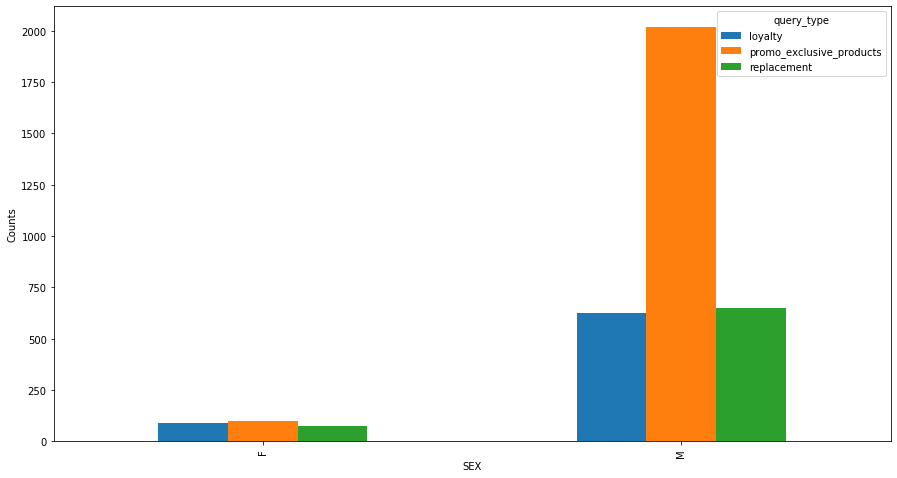

In [246]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="bar",figsize=(15,8))
_= ax.set_ylabel("Counts")

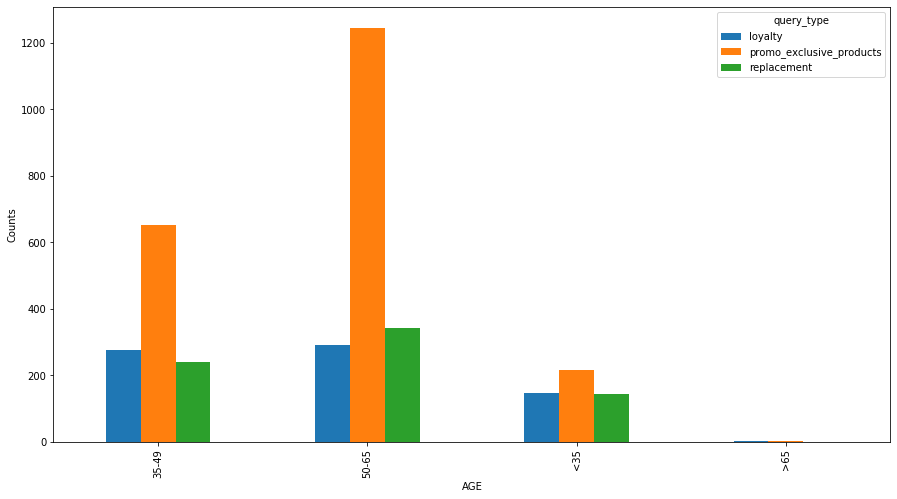

In [247]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="bar",figsize=(15,8))
_= ax.set_ylabel("Counts")

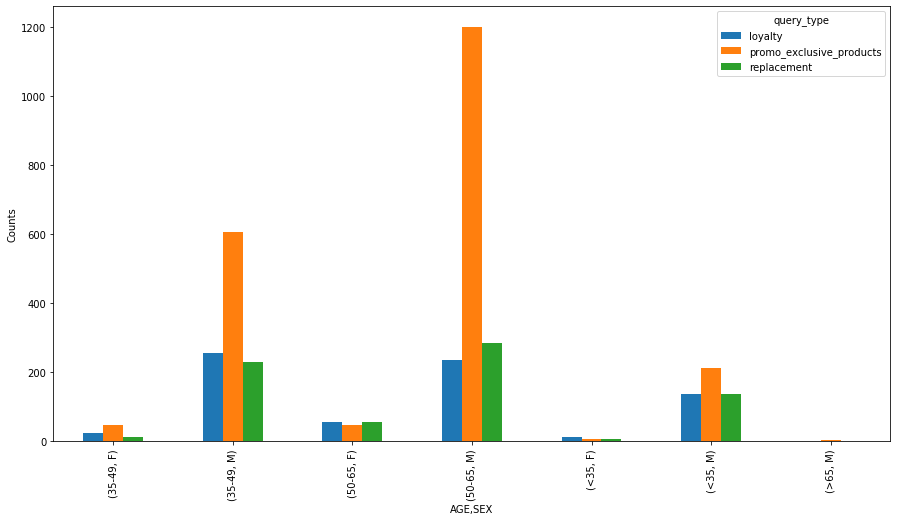

In [253]:
ax = stats_df.groupby(["AGE","SEX"])["query_type"].value_counts().unstack().plot(kind="bar",figsize=(15,8))
_= ax.set_ylabel("Counts")

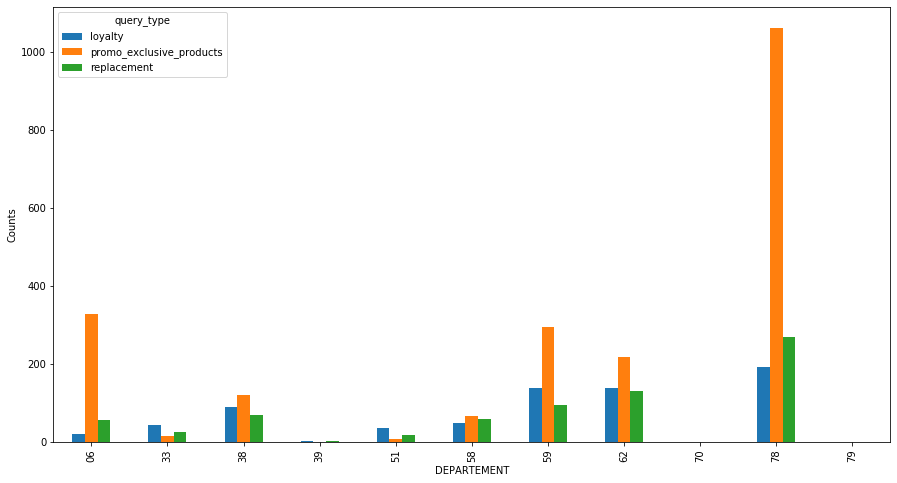

In [254]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="bar",figsize=(15,8))
_= ax.set_ylabel("Counts")